Whilst Spark is amazing at handling big data sets, it isn't a great idea to plot all of it. We suggest taking a maximum of 5% of records for the tutorial. 

You can up it to your requirements, but we recommend sticking to less than 1 million records per month for visualization purposes.

**Project 1 Checklist:**
- You have justified your sample size (i.e due to runtime, distribution of data, etc)
- You have justified your sampling method (i.e random, stratified, etc)
- You have detailed in your report that you have sampled for visualization purposes BUT your analysis still uses the full distribution of data
- You mention any issues that can potentially be caused by sampling (i.e biased visualisation if using random)

Remember, it is your responsibility as the student (future Data Scientist) to convince the tutor (your stakeholders) that your justifications and assumptions are correct!

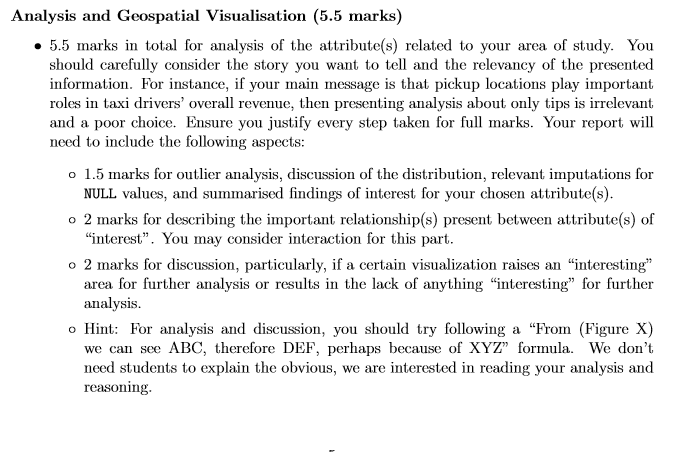

In [3]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC") # fix timestamps loaded by spark
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/19 01:03:29 WARN Utils: Your hostname, DESKTOP-SATV84A resolves to a loopback address: 127.0.1.1; using 172.26.254.29 instead (on interface eth0)
23/08/19 01:03:29 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 01:03:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/08/19 01:03:30 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


# Temporal Analysis

#### (Note that dataset shape can be distribution and / or dimensionality)

In [35]:
import pandas as pd
import seaborn as sns

In [36]:
# load in data
df = pd.read_parquet("../data/curated/combined_imputed.parquet")

In [37]:
sdf = spark.createDataFrame(df)

In [38]:
# use spark to group into averages by location
from pyspark.sql import functions as F

sdf = sdf.withColumn(
    'Type of Day', 
    F.when(
           (F.col('is_public_holiday') == True),
           "Public Holiday"
        ).when(
            (F.col('is_weekday') == True),
            "Weekday"
        ).otherwise("Weekend")
    )
 
df_hours = sdf.groupBy(['hour', 'Type of Day']) \
            .agg(
                F.avg('avg_usd_per_1/5_mile').alias('avg_usd_per_1/5_mile'),
                F.avg('avg_usd_per_minute').alias('avg_usd_per_minute'),
                F.avg('number_of_trips_here').alias('avg_hourly_trips'),
                F.avg('zone_profitability').alias('avg_hourly_zone_profitability')
            ).withColumn(
                'log_zone_profitability', F.log('avg_hourly_zone_profitability')
            ).toPandas()
            


23/08/19 01:17:10 WARN TaskSetManager: Stage 42 contains a task of very large size (6949 KiB). The maximum recommended task size is 1000 KiB.


In [39]:
df_hours.sort_values(by='avg_hourly_trips', ascending=False).head(24)

,hour,Type of Day,avg_usd_per_1/5_mile,avg_usd_per_minute,avg_hourly_trips,avg_hourly_zone_profitability,log_zone_profitability
12,18,Weekday,1.836574,1.489338,48.329732,173.872392,5.158322
70,19,Weekday,1.748796,1.577416,45.282949,160.994714,5.081372
5,17,Weekday,1.901831,1.426360,44.260088,159.545592,5.072330
20,21,Weekday,1.546302,1.580260,39.444811,130.473020,4.871166
54,20,Weekday,1.628211,1.568358,39.056137,131.888928,4.881960
45,15,Weekday,1.755253,1.362915,37.733494,123.500616,4.816246
64,14,Weekday,1.758523,1.359543,37.443705,124.301866,4.822713
21,18,Weekend,1.632198,1.475871,36.645007,118.471916,4.774676
27,16,Weekday,1.905447,1.415522,36.169623,131.232258,4.876969
52,17,Weekend,1.638643,1.457179,35.283162,113.448706,4.731351


In [40]:
df_hours = df_hours.sort_values(by='Type of Day')

[Text(0.5, 0, 'Hour of Day (24H)'),
 Text(0, 0.5, 'Average Hourly Zone Profitability'),
 Text(0.5, 1.0, 'Average Hourly Taxi Zone Profitability NYC May-November 2022')]

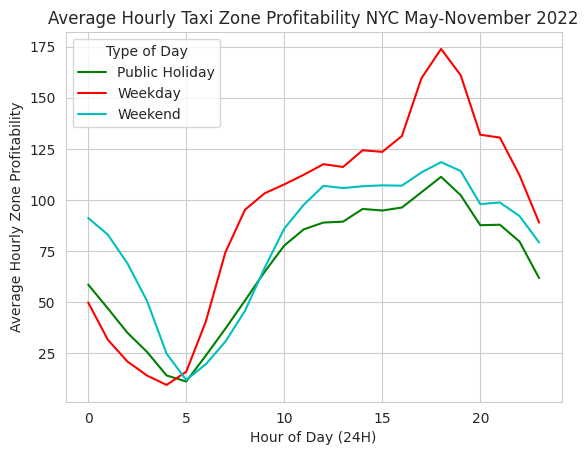

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

sns.lineplot(data=df_hours, x='hour', y='avg_hourly_zone_profitability', hue='Type of Day', palette=['g','r','c']).set(xlabel='Hour of Day (24H)', ylabel='Average Hourly Zone Profitability', title='Average Taxi Zone Profitability by Hour in NYC May-November 2022')

## Research Goal: 
### - Which type of vehicle driver makes the most money per hour and why
### - Which periods of the year do vehicle drivers make the most money during and why (could use external datasets of when and where social events are occurring which increase taxi / fhv demand)
### - Which regions of NYC do vehicle drivers make the most money during and why
### - How can taxi / fhv drivers maximise tip amounts in general
### - When and where are traffic levels lowest during the year / day for NYC (requires external datasets)

### Could also go the passenger route
### - Which taxi / fhv service provides the cheapest service over the same distance
### - Which taxi / fhv service leads to the most pleasant experience (driver ratings, frequency of sharing with different passengers, wait times, etc.)